# Assignment 3 

Project Name: Assignment 3 – Machine Learning Portfolio: Comparing the Performance of Machine Learning Approaches for Activity Classification <br>
Authors: - <br>
Email: - <br>
Date: - 12/08/24<br>

#### WORK IN PROGRESS 

Activity classification is the process of caputuring human movement using certain devices such as Inertial Measurement Unit's (imus) and creating machine learning classification models to be able to tell what type of movement is being performed. It is a common task performed daily by most popular devices like smart watches and phones.

In this project we will be taking two separate datasets, one comprised of x, y, and z points from an Inertial Measurement Unit (imu) and the second set being a series of annotated values from a video recording of the same human movements. We will be taking these two dataset:
- Combining them together and aligning their time values
- Calculating a new set of metrics to create a set of features
- Training a series of classifiers on these new features
- Implementing optimization of hyper parameters to fine tune the models
- Creating a series of visualization to show the training decisions and final outcomes
- Concluding on the results we have found





In [1]:
# Import statements, we might not use all these

import math
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error

## Load data

We will begin by loading up our data sets and running through the beginning checklist of any data science project. This includes<br>
inspecting our data sets, checking for missing values and fixing any preliminary probelms we might see before moving onto the steps.

In [4]:
# function to load csv files as pandas dataframe

def load_data(csv, header, col_names):
    """
    Takes a csv's file path in the form of a string and 
    returns a pandas dataframe of the csv, if the dataset
    has no column names, it will append a passed in list
    of column names, otherwise it will leave the dataset 
    as is.
    Params:
    String - csv, string of the file path for a given csv
    header - Paramater deciding if the first row of the csv 
    are the column names or not, pass "infer" if your data
    set has column names and "None" if it doesn't
    names - A list of column names to assign to the dataset
    only if the headers parameter is "None", pass None for
    this parameter if your dataset already has column names.
    Returns:
    Pandas dataframe of a csv file
    """
    return pd.read_csv(csv, header=header, names=col_names)    

In [5]:
# File paths for our csv data sets
IMU_DATA = "./a3_imu_data.csv"
ACTIVITY_DATA = "./a3_activity_annotations.csv"

Looking at the raw csv files outside of the project, we noticed that the imu data set has no column names, we are going to need<br>
to assign the data set column names so that it is easier/possible to work with. The names chosen were taken from the assignments <br>
task sheet. The activity data already had column names assigned and accurate, so no work was neccersary on them.

In [7]:
# Initialing our datasets as pandas dataframes and assigning column names

# List of column namesColumn 
imu_col_names = ["timestamp", "x_axis_accel", "y_axis_accel", "z_axis_accel", "x_axis_gyro", "y_axis_gyro", "z_axis_gyro"]

# Loading our csv files, the imu set has no column names so we are passing in a list of names to add
# The activity dataset comes with names so we leave it as it is and pass in "None" for column names
imu_data_raw = load_data(IMU_DATA, None, imu_col_names)
activity_data_raw = load_data(ACTIVITY_DATA, "infer", None)

That should do the job, now let's look and see what our datasets look like, check for missing values, and plot a basic visualization<br> of the data sets.

In [9]:
# Function to check for any null values

def check_for_null(dataset, name):
    """
    Takes a pandas dataframe and the name of the dataframe as a string and
    checks if there are any missing values in all columns, prints out the 
    results
    Params:
    dataset - A pandas dataframe 
    name - A string for the name of your dataframe
    """
    print(f"{name}'s NULL values \n")
    for col in dataset.columns:
        print(f"{dataset[col].name} has {dataset[col].isnull().sum()} null values")

In [10]:
# Function to display a basic plot of our data

def plot_dataframe(X, y, title):
    """
    Takes an X and y from a pandas dataseries as well as the title in the form of a string. 
    The X value should be a single column of values from a pandas dataframe, the y values
    can contain as many columns as you like.
    Params:
    X - Pandas series containing the x value for our plot
    y - Pandas series containing the y value(s) for our plot
    title - String containing the desired title for our plot
    """
    # Create a figure
    fig, ax = plt.subplots(figsize=(18,10))

    # for every column in the y set, get the column name and append it to a list of labels
    
    labels=[i for i in y.columns]

    # Plot the data and add basic quality of life features
    plt.plot(X, y, label= labels)
    ax.set_xlabel(X.name, fontsize=18)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_ylabel("Values", fontsize=18)
    ax.set_title(title, fontsize=22)
    plt.grid()
    plt.legend()

## Visualize the datasets and inspect for alignment errors

### IMU Dataset Inspection

In [17]:
# Check for null values
check_for_null(imu_data_raw, "IMU DATA")


IMU DATA's NULL values 

timestamp has 0 null values
x_axis_accel has 0 null values
y_axis_accel has 0 null values
z_axis_accel has 0 null values
x_axis_gyro has 0 null values
y_axis_gyro has 0 null values
z_axis_gyro has 0 null values


In [20]:
# Get basic information
imu_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71242 entries, 0 to 71241
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   timestamp     71242 non-null  int64
 1   x_axis_accel  71242 non-null  int64
 2   y_axis_accel  71242 non-null  int64
 3   z_axis_accel  71242 non-null  int64
 4   x_axis_gyro   71242 non-null  int64
 5   y_axis_gyro   71242 non-null  int64
 6   z_axis_gyro   71242 non-null  int64
dtypes: int64(7)
memory usage: 3.8 MB


In [21]:
# Visualise the dataframe
imu_data_raw.head()

,timestamp,x_axis_accel,y_axis_accel,z_axis_accel,x_axis_gyro,y_axis_gyro,z_axis_gyro
0,1598240213,-2402,1710,-380,-1413,-362,223
1,1598240213,-1880,1688,-420,-1469,-597,-23
2,1598240213,-1558,1568,-606,-1535,-872,-195
3,1598240213,-1154,1732,-654,-1293,-976,-335
4,1598240213,-452,2084,-754,-719,-940,-214


From above we can see that that our timestamps are calculated as unix time stamps, we might want to convert these to seconds before we plot <br>
the series to avoid some unpretty looking axis values. This will also come in handy later on in this project when aligning the two dataset's. <br>


In [24]:
# Creating a function specifically to convert unix time stamps to seconds

def convert_time_series(data_series):
    """
    Converts a series consisting of unix timestamps to seconds and returns the series
    Params:
    data_series - a pandas dataseries of unix timestamps
    Returns:
    A time series in seconds
    """
    # Assign the timestamp to a variable
    time = data_series

    # Create a starting time outside of our loop so that it doesn't change value
    # as we iterate through each value of the series
    start_time = time[0]
    
    # Iterate through every value of the timestamp column
    for row in time:
        # Get the time in the timstamp column, minus the first value, and plus 1,
        # this will essentially count seconds from the start of the dataseries
        calc_seconds = row - start_time + 1
        # Take the value calculated above and replace it in our time column, this
        # will remove the unix timestamp from the column and replace it with the
        # difference in seconds since the start of the dataseries
        time = time.replace(to_replace=row, value=calc_seconds)
    
    # Add the new time series to our dataframe
    return time

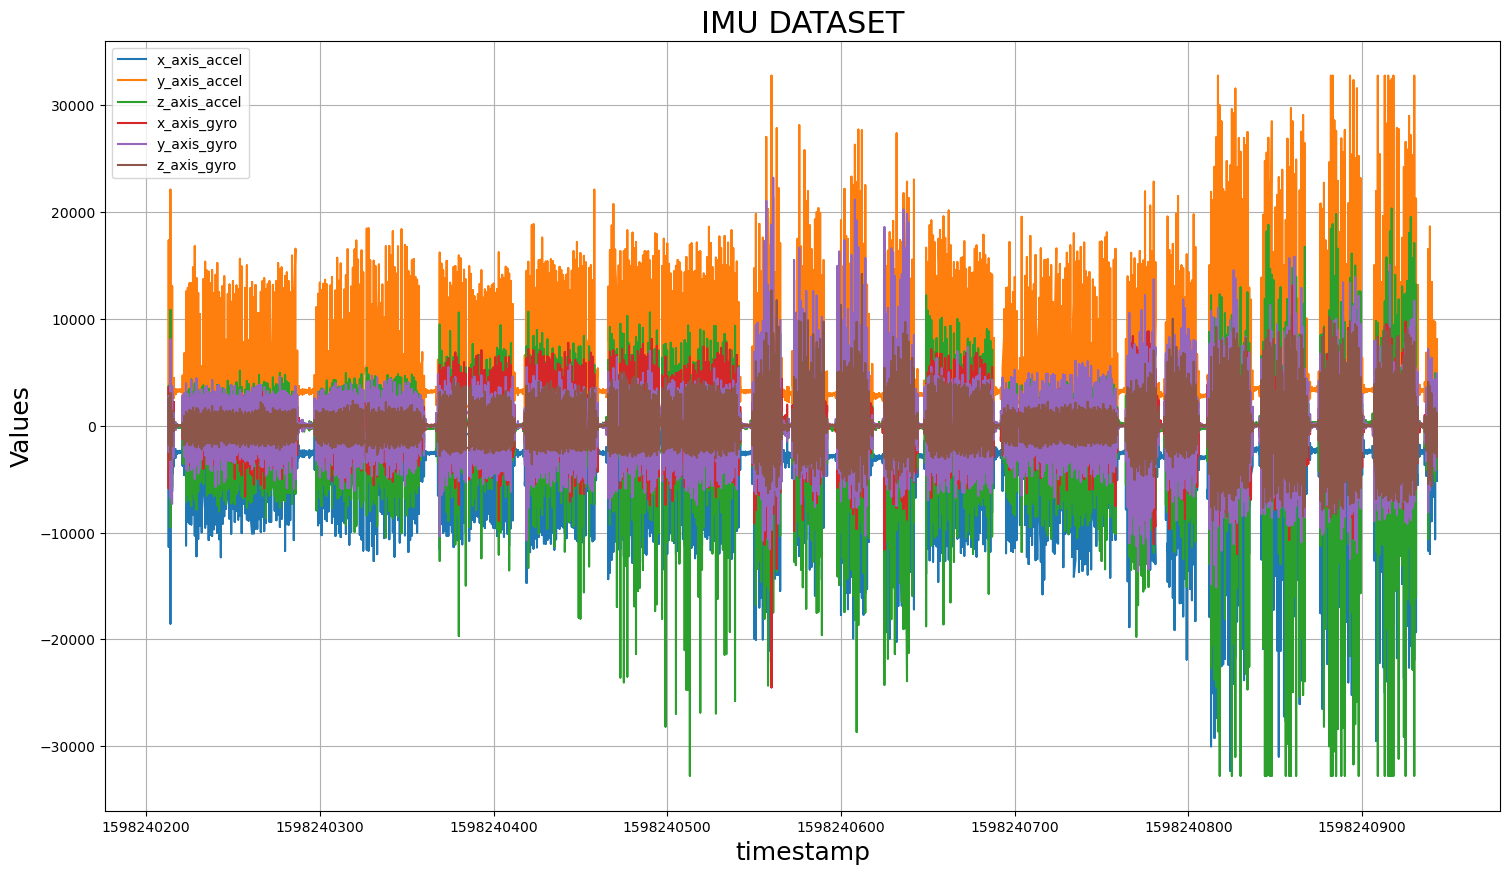

In [26]:
# Call the plot_dataframe function passing it our dataframes timestamp column for the X axis and every other column for our y values

imu_data_raw["time (seconds)"] = convert_time_series(imu_data_raw["timestamp"])

plot_dataframe(imu_data_raw["timestamp"],  imu_data_raw.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")

By the looks of it, our IMU dataset looks pretty straight forward:
- There are no null values
- We were able to correctly name the columns
- There are 71,000 samples of data
- All data values are integers
- The timestamp are unix time stamps
- We have created a new column value "time (seconds)" <br>
that tracks the time from the start of the data to <br>
any given point in seconds
<br>

One thing that stands out when visualizing this dataset is the start and end points of the data don't really match any other sections of the set, depending on <br>
what our activity data looks like, we may have to slice out these points to align the data more accuratly. Another thing of note is the different sections of<br>
of the dataset. There appears to be 17 different movement sections with 4 or 5 different movement patterns, another thing to look out for when we are aligning <br>
our data.
Let's move onto our activity data set now and see what are working with and what we might have to fix

### Activity Dataset Inpection

In [31]:
check_for_null(activity_data_raw, "ACTIVITY DATA")

ACTIVITY DATA's NULL values 

image has 0 null values
xmin has 0 null values
ymin has 0 null values
xmax has 0 null values
ymax has 0 null values
label has 0 null values


In [32]:
activity_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   34 non-null     object 
 1   xmin    34 non-null     float64
 2   ymin    34 non-null     float64
 3   xmax    34 non-null     float64
 4   ymax    34 non-null     float64
 5   label   34 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.7+ KB


In [33]:
activity_data_raw.head()

,image,xmin,ymin,xmax,ymax,label
0,a3.mp4#t=0.0,868.943127,417.331032,919.139168,557.535077,Walking
1,a3.mp4#t=66.2,854.251592,330.392238,926.484935,564.882015,Standing
2,a3.mp4#t=75.4,855.475924,324.882034,929.545709,561.820810,Walking
3,a3.mp4#t=139.333333,849.966598,321.208565,928.933599,563.045281,Standing
4,a3.mp4#t=146.733333,855.475924,327.331004,935.667145,553.249400,Jogging


Similiarly like with the IMU dataset our Activity Dataset has a "not so straight forward" timestamp series, this is under the column named "image" and appears to <br>
be in the form of a string. We do need the time values from this set so that we can align our datasets later on. Fortunately it should be easy to create a clean<br>
set of data for time series from these values. Moving onto the other non-number series of data in the dataset, the labels. These will be our targets/labels/y-series<br>
that we will use to train our classifiers on later on, the rest of the data we don't need for this project. Let's fix our time series and then figure out what to plot.

In [35]:
# Create a list to append our new time values too
time = []

# Iterate through every row of the "image" column
for row in activity_data_raw.image:
    # Split the row on the "=" and append only the second element as this is float
    # value that appears after the equals and not the a3.mp4# that appears before.
    time.append(float(row.split("=")[1]))

# Add the new series to our dataframe
activity_data_raw["time"] = time
activity_data_raw.head()

,image,xmin,ymin,xmax,ymax,label,time
0,a3.mp4#t=0.0,868.943127,417.331032,919.139168,557.535077,Walking,0.000000
1,a3.mp4#t=66.2,854.251592,330.392238,926.484935,564.882015,Standing,66.200000
2,a3.mp4#t=75.4,855.475924,324.882034,929.545709,561.820810,Walking,75.400000
3,a3.mp4#t=139.333333,849.966598,321.208565,928.933599,563.045281,Standing,139.333333
4,a3.mp4#t=146.733333,855.475924,327.331004,935.667145,553.249400,Jogging,146.733333


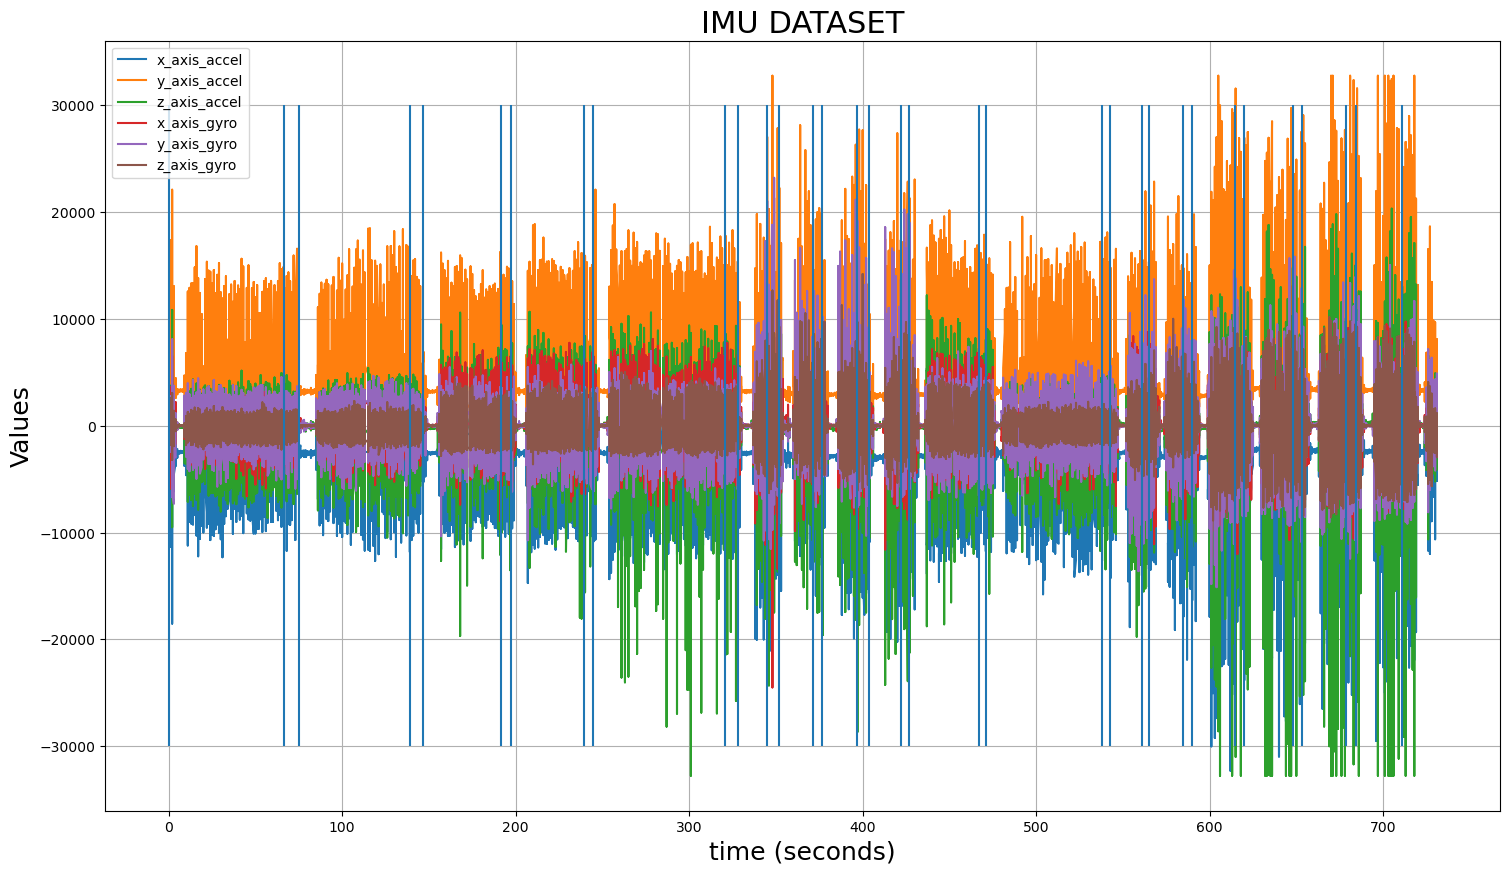

In [36]:
# Re-plot our IMU data and overlay the time points inthe activity dataset where the labels change
plot_dataframe(imu_data_raw["time (seconds)"],  imu_data_raw.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")

# Add vertical lines for every activity change
plt.vlines(activity_data_raw["time"], -30000,30000)
plt.show()

In [37]:
# Printing the first value of our labels series
activity_data_raw.label[0]

'Walking'

Ok, so from the above plot we can see that our data is not aligned, judging by the small gaps between the vertical lines, and the fact that the first activity label is walking,<br>
the small blip of imu data at the start needs to be removed and we need our imu dataset to start a little later where the first section of consistancy begins. This should <br>
solve the alignment problem of our datasets, we also need to remove the last section of the imu data after the last section of consistancy. To find what values we need to slice <br>
out, we can use some trial and error passing in sliced sections of our imu dataset to our plot function and finding the exact values we need. Afterwards we can reassign our data<br>
frame without the uneeded rows of data and then re-adjust the time series again.

## Align and combined the activity and imu datasets using the activity transitions

In [40]:
# Slice up our imu data to remove unwanted start and end data
imu_processed = imu_data_raw.drop(["time (seconds)"], axis=1)[900:70000]

# reset the inde on the dataframe and drop the old index column
imu_processed = imu_processed.reset_index().drop("index", axis=1)
imu_processed.head()

,timestamp,x_axis_accel,y_axis_accel,z_axis_accel,x_axis_gyro,y_axis_gyro,z_axis_gyro
0,1598240222,-2602,2848,-3576,-413,-51,-205
1,1598240222,-2850,2936,-3502,-315,-1,-123
2,1598240222,-3172,2890,-3450,-248,114,-17
3,1598240222,-3340,2772,-3240,-236,273,60
4,1598240222,-3346,2566,-3114,-287,469,83


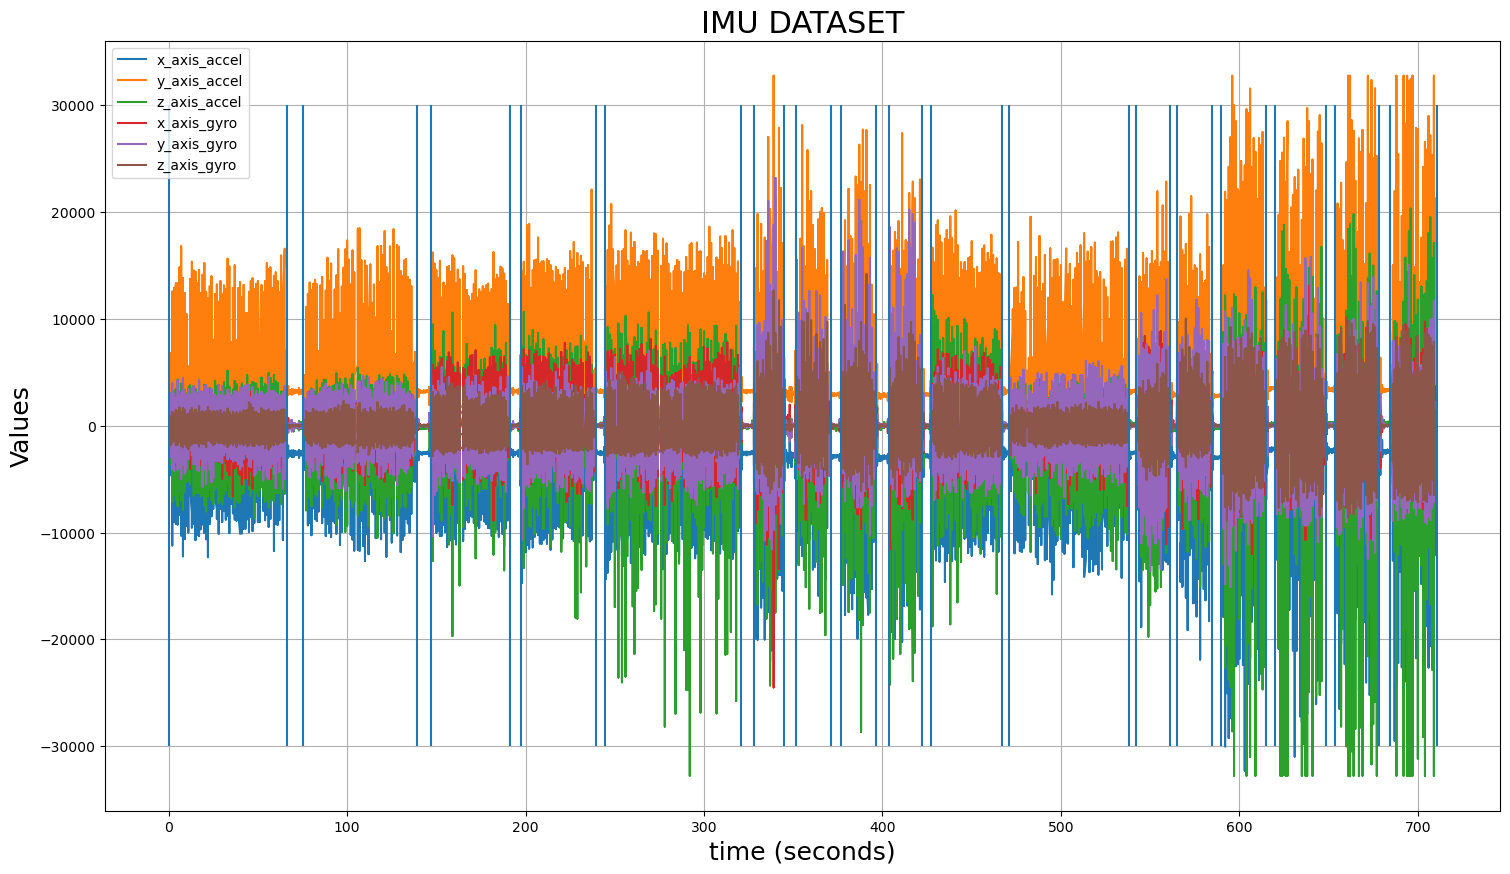

In [41]:
# Re-call the unix timestamp converter to re-adjust the time values
imu_processed["time (seconds)"] = convert_time_series(imu_processed["timestamp"])

plot_dataframe(imu_processed["time (seconds)"],  imu_processed.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")

plt.vlines(activity_data_raw["time"], -30000,30000)
plt.show()

## Process the activity annotation data to assign a target activity to each data point within the IMU dataset.

In [43]:
# Setting an index for the activity label data row
index=1

# Creating a list to hold our activity labels
label=[]

# Iterating through every row of our imu dataset
for row in range(len(imu_processed)):

    # If the time for any given row in our imu data is less than the time in our activity data, we are appending the 
    # label from the activity data to our list of activity labels. Since the activity data's time starts at 0.00, this 
    # will throw our labels off by one row, so we minus 1 when appending to ensure we get the correct label assigned.
    if imu_processed["time (seconds)"][row] <= activity_data_raw.time[index]:
        label.append(activity_data_raw.label[index-1])
    # if the time for a given row from our imu data is greater then the current time in our activity data, we increment
    # the index by one, shifting our activity data to the next row, and continue to append whatever the activity label
    # is for that row to our activity list.
    else: 
        index +=1
        label.append(activity_data_raw.label[index-1])

# Create a new column in our imu dataset with our new labels which will be our targets for training.
imu_processed["label"] = label

# Sanity check to make sure all worked out
# for x in imu_processed["label"]:
#     print(x)
imu_processed.head()

,timestamp,x_axis_accel,y_axis_accel,z_axis_accel,x_axis_gyro,y_axis_gyro,z_axis_gyro,time (seconds),label
0,1598240222,-2602,2848,-3576,-413,-51,-205,1,Walking
1,1598240222,-2850,2936,-3502,-315,-1,-123,1,Walking
2,1598240222,-3172,2890,-3450,-248,114,-17,1,Walking
3,1598240222,-3340,2772,-3240,-236,273,60,1,Walking
4,1598240222,-3346,2566,-3114,-287,469,83,1,Walking


So now we have our labels from our activity dataset appeneded to our imu dataset and everything is sliced up and aligned. We have time counted in seconds instead <br>
of unix timestamps, all we need to do before firing up our classifiers is to create some features from our data to train the classifiers on. This is what we will <br>
now turn our attention to in the next section.

## Calculate a set of features from the raw sensor data.

### Feature functions

#### Mean

In [48]:
# Function to calculate the mean for a series.

def calculate_mean(time_series, target_series, time_steps):
    """
    Calculates the mean of a pandas data series for a given period of time

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of data to calculate the mean on
    time_steps - The timeframe (i.e number of seconds) to calculate the mean over
    Returns:
    mean - A list of averages from the target_series calculated over the given time_steps. 
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_steps
    # the cumulative total of values
    cumsum = 0
    # the number of entries that have been added together
    divisor = 0
    # list to hold the averages to be returned
    mean = []

    # iterate through every row of the dataframe
    for row in range(len(time_series)):

        # if the time in the dataframe is less then the desired time steps ie. if the current
        # row's time in seconds is less then the desired total time to calculate the mean over
        if time_series[row] <= seconds:
            # add the rows data to the sum
            cumsum += target_series[row]
            # increment the divors by 1
            divisor += 1
        # otherwise if the above is not the case, then the next row of data's time has gone up
        # i.e we have reached the end of the calculatable period
        else:
            # safety net for divide by zero case
            if divisor != 0:
                # divide the total accumulated sum by the amount of entries, and append it to the list
                mean.append(round(cumsum/divisor, 6))
            else:
                # append 0 if there were no values, (we can deal with zero values later)
                mean.append(0)
            # Reset all of the variables for the next time step
            divisor = 0
            cumsum = 0
            cumsum += target_series[row]
            seconds += time_steps

    return mean

#### Max value

In [50]:
# Function to calculate the max values

def calculate_max(time_series, target_series, time_steps):
    """
    Calculates the max value of each step in a given time period in a pandas series

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of data to calculate the max on
    time_steps - The timeframe (i.e number of seconds) to calculate the max over
    Returns:
    max_ls - A list of max values from the target_series calculated over the given time_steps. 
    
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_steps
    # Default value for max
    max = 0
    # list to hold the max values to be returned
    max_ls = []

    # iterate through every row in the dataseries
    for row in range(len(imu_processed["time (seconds)"])):

        target = target_series[row]
        # for every value in the current time step, check if the value of max is 
        # greater then the current row of data, if it isnt, replace it with the
        # current row of data for the current time step
        if time_series[row] <= seconds:
            if target > max:
                max = target
        else:
            # if the time_series is greater then the current time step, than append
            # the max value to the list, and increment the values for the next time step
            max_ls.append(round(max, 6))
            seconds += time_steps
            max = target

    return max_ls

#### Min value

In [52]:
# Function to calculate the min values

def calculate_min(time_series, target_series, time_steps):
    """
    Calculates the min value of each step in a given time period in a pandas series

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of data to calculate the min on
    time_steps - The timeframe (i.e number of seconds) to calculate the min over
    Returns:
    min_ls - A list of min values from the target_series calculated over the given time_steps. 
    
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_steps
    # Default value for max
    min = 0
    # list to hold the max values to be returned
    min_ls = []

    # iterate through every row in the dataseries
    for row in range(len(imu_processed["time (seconds)"])):

        target = target_series[row]
        # for every value in the current time step, check if the value of max is 
        # greater then the current row of data, if it isnt, replace it with the
        # current row of data for the current time step
        if time_series[row] <= seconds:
            if target < min:
                min = target
        else:
            # if the time_series is greater then the current time step, than append
            # the max value to the list, and increment the values for the next time step
            min_ls.append(round(min, 6))
            seconds += time_steps
            min = target

    return min_ls

#### Signal Magnitude Area

In [54]:
# Function to calculate the signal magnitude area

def calculate_signal_magnitude_area(time_series, x, y, z, time_step):
    """
    Calculates the signal magnitude area of a given x, y and z pandas series for a
    given time period 

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    x - An x series of data to be used for hte signal magnitude 
    y - An y series of data to be used for the signal magnitude 
    z - An z series of data to be used for the signal magnitude 
    time_steps - The timeframe (i.e number of seconds) to calculate the signal magnitude over
    Returns:
    sma - A list of signal magnitude values from the x, y, z, target series calculated over the given time_steps. 
    """
    # length of time to calculate mean over, ie 1 = 1 second, 5 = 5 seconds, etc
    seconds = time_step
    # the cumulative total of values
    cumsum = 0
    # the number of entries that have been added together
    divisor = 0
    # a list to hold all of the signal magnitude features
    sma = []

    # Iterates through all rows of the time series
    for i in range(len(time_series)):

        # if the time in the dataframe is less then the desired time steps ie. if the current
        # row's time in seconds is less then the desired total time to calculate the value over
        if time_series[i] <= seconds:
            # add the values of all three series to the cumulative total
            cumsum += x[i] + y[i] + z[i]
            # Increment the divisor by 1
            divisor += 1
        else:
            # if the divisor isnt 0
            if divisor != 0:
                # multiply negative values by -1 to get the absolute value
                if cumsum < 0:
                    cumsum = cumsum * -1
                # divide the absolute value by the number of samples and append result to the list
                sma.append(round(cumsum/divisor, 6))
            else:
                # append 0 if the divisor was 0, ie no samples over the time period
                sma.append(0)
            # reset all the values for the time step
            cumsum = 0
            cumsum += x[i] + y[i] + z[i]
            seconds += time_step

    return sma

#### Average Intensity

In [56]:
def calculate_average_intensity(time_series, x, y, z, time_step):
    """
    Calculates the average intensity of a given x, y and z pandas series for a
    given time period 

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    x - An x series of data to be used for the average intensity
    y - An y series of data to be used for the average intensity 
    z - An z series of data to be used for the average intensity
    time_steps - The timeframe (i.e number of seconds) to calculate the average intensity over
    Returns:
    ai - A list of average intensity values from the x, y, z, target series calculated over the given time_steps. 
    """
    seconds = time_step
    xsum, ysum, zsum = 0, 0, 0

    divisor = 0
    # list to hold the average intensity values
    ai = []
    for i in range(len(time_series)):

        # if the time in the dataframe is less then the desired time steps ie. if the current
        # row's time in seconds is less then the desired total time to calculate the value over
        if time_series[i] <= seconds:
            
            xsum += x[i]
            ysum += y[i]
            zsum += z[i]
            # Increment the divisor by 1
            divisor += 1
        else:
            # if the divisor isnt 0, square the values
            if divisor != 0:
                xsum = xsum**2
                ysum = ysum**2
                zsum = zsum**2

                # TAKE THE SQUARE ROOOOT
                sqrt = math.sqrt(xsum+ysum+zsum)

                # divide the value by the amount of samples and add it to the list
                ai.append(round(sqrt/divisor, 6))
            else:
                # Append 0 if the divisor is 0, i.e there were no samples
                ai.append(0)
            # Reset all the values for the next time_step
            xsum, ysum, zsum = 0, 0, 0

            xsum += x[i]
            ysum += y[i]
            zsum += z[i]
            seconds += time_step
    return ai

#### Acitivity Labels

In [58]:
# Function for activity labels

def assign_labels(time_series, target_series, time_steps):
    """
    Assigns the activity value of each step in a given time period in a pandas series

    Params:
    time_series - A pandas series used to keep track of time for values in the target_series
    target_series - A pandas series of our activity values to assign 
    time_steps - The timeframe (i.e number of seconds) to calculate which activity is being performed
    Returns:
    Activity - A list of activity values from the target_series calculated over the given time_steps. 
    
    """
    
    seconds = time_steps

    activity = []
    # Iterate through all rows of the dataframe and assign a target activity label for each time step
    for row in range(len(time_series)):
        # similiar to the features functions above, if the current row of the time series has the same
        # value of time as the time_step, then continue to the next row
        if time_series[row] <= seconds: continue
        # if the value in the time series is now greater then the current time_step, then append the last
        # activity to the list, this will be the label for that time_step
        else:
            # Assign the last label to the list
            activity.append(target_series[row-1])
            seconds += time_steps
    return activity

### Create a new Dataframe made of our new features

In [60]:
# Create a new dataframe to hold all of our features
imu_features = pd.DataFrame()

# Set a time step to calculate all features over, this is the amount of seconds that each feature should be calculated 
# over, be warned, when increasing this number it doesn't take long for the accuracy of the features to drop 
# dramatically as you are calculating over longer time periods with activity changes.
time_steps = 2

# time series of values
time_series = imu_processed["time (seconds)"]

# Mean features
imu_features["x_accel_mean"] = calculate_mean(time_series, imu_processed["x_axis_accel"], time_steps)
imu_features["y_accel_mean"] = calculate_mean(time_series, imu_processed["y_axis_accel"], time_steps)
imu_features["z_accel_mean"] = calculate_mean(time_series, imu_processed["z_axis_accel"], time_steps)
imu_features["x_gyro_mean"] = calculate_mean(time_series, imu_processed["x_axis_gyro"], time_steps)
imu_features["y_gyro_mean"] = calculate_mean(time_series, imu_processed["y_axis_gyro"], time_steps)
imu_features["z_gyro_mean"] = calculate_mean(time_series, imu_processed["z_axis_gyro"], time_steps)

# max features
imu_features["x_accel_max"] = calculate_max(time_series, imu_processed["x_axis_accel"], time_steps)
imu_features["y_accel_max"] = calculate_max(time_series, imu_processed["y_axis_accel"], time_steps)
imu_features["z_accel_max"] = calculate_max(time_series, imu_processed["z_axis_accel"], time_steps)
imu_features["x_gyro_max"] = calculate_max(time_series, imu_processed["x_axis_gyro"], time_steps)
imu_features["y_gyro_max"] = calculate_max(time_series, imu_processed["y_axis_gyro"], time_steps)
imu_features["z_gyro_max"] = calculate_max(time_series, imu_processed["z_axis_gyro"], time_steps)

# min features
imu_features["x_accel_min"] = calculate_min(time_series, imu_processed["x_axis_accel"], time_steps)
imu_features["y_accel_min"] = calculate_min(time_series, imu_processed["y_axis_accel"], time_steps)
imu_features["z_accel_min"] = calculate_min(time_series, imu_processed["z_axis_accel"], time_steps)
imu_features["x_gyro_min"] = calculate_min(time_series, imu_processed["x_axis_gyro"], time_steps)
imu_features["y_gyro_min"] = calculate_min(time_series, imu_processed["y_axis_gyro"], time_steps)
imu_features["z_gyro_min"] = calculate_min(time_series, imu_processed["z_axis_gyro"], time_steps)

# Signal magnitude area
imu_features["sma_accel"] = calculate_signal_magnitude_area(time_series, imu_processed["x_axis_accel"], imu_processed["y_axis_accel"], imu_processed["z_axis_accel"], time_steps)
imu_features["sma_gyro"] = calculate_signal_magnitude_area(time_series, imu_processed["x_axis_gyro"], imu_processed["y_axis_gyro"], imu_processed["z_axis_gyro"], time_steps)

# average intensity
imu_features["ai_accel"] = calculate_average_intensity(time_series, imu_processed["x_axis_accel"], imu_processed["y_axis_accel"], imu_processed["z_axis_accel"], time_steps)
imu_features["ai_gyro"] = calculate_average_intensity(time_series, imu_processed["x_axis_gyro"], imu_processed["y_axis_gyro"], imu_processed["z_axis_gyro"], time_steps)

# Label feature
imu_features["target"] = assign_labels(time_series, imu_processed["label"], time_steps)

# # Finally add time in seconds to our new dataframe
time = []
steps = 1
# iterate through all row of activites and append a value of time
for row in range(len(imu_features)):
    time.append(steps)
    steps += 1

# add the list to the features dataframe 
imu_features["time"] = time


### Plotting our Features along with the activity markers

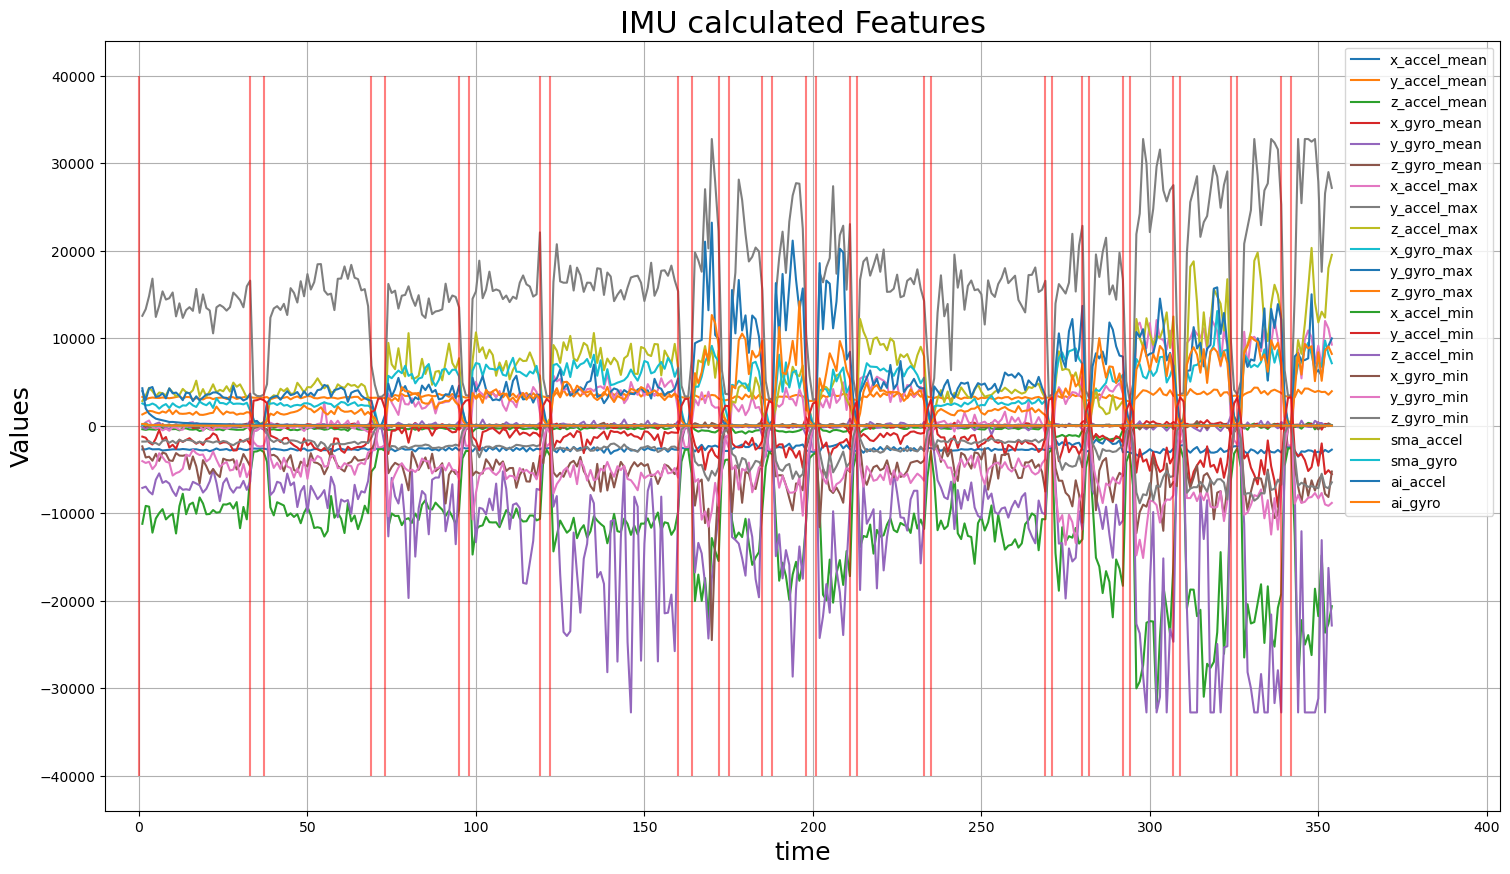

In [62]:
# Since the time steps can change depending on if we want 1, 2, 3, etc second itervals to calculate
# our features over, we have to make sure the activity transitions move with the time steps, below
# is a loop that creates a list of activity transitions depending on the value in the data series
activity_markers = [0]
# Set a variable to keep track of the current activity we are up to
current_label = imu_features["target"][0]
# iterate through all rows of the target labels, ie "walking", "jogging", etc
for row in range(len(imu_features["target"])):
    # if the current activity isnt the same as the target row, append the value to the list and 
    
    if current_label != imu_features["target"][row]:
        activity_markers.append(row)
        # change the current activity to the freshly added value to our list
        current_label = imu_features["target"][row]

# plot the new dataframe with the calculated features and add the vertical lines from the activity series to check it lines up
plot_dataframe(imu_features["time"], imu_features.drop(["target", "time"], axis=1), "IMU calculated Features")

# Plot the vertical lines associated with our activity transitions
plt.vlines(activity_markers, -40000,40000, color="r", alpha=0.5)
plt.xlim(-10, len(imu_features) + 50)
plt.show()

Ok so from the above plot we can now see that we were successfully able to transform our data from raw values into a set of features to be used <br>
for classfication. We chose to use the mean, max, min, signal magnitude, and average intensity values for each axis. Now onwards to training our<br>
classifiers!


## Apply a machine learning workflow to train classifiers (Feel free to change any of the below sections)

In [65]:
# Assign our target values to a new variable
labels = imu_features.target

# Create a label encoder object to encode our string values into integers
lb = LabelEncoder()
# Fit the encoder
labels = lb.fit_transform(labels)

# Sanity check the labels
# lb.classes_
# ceck it worked
# labels

In [66]:
# Create our test train splits
X_train, X_test, y_train, y_test = train_test_split(imu_features.drop(["time", "target"],axis=1), labels, test_size=0.3, random_state=42)

In [67]:
# Scale our data for classification use 
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
# rnd = RandomForestClassifier(n_estimators=100)
# rnd_fit = rnd.fit(X_train,y_train)
# rnd_cross_val = cross_val_score(rnd, X_train, y_train, cv = 5)
# rnd_f1 = cross_val_score(rnd, X_train, y_train, cv = 5, scoring ="f1_macro")
# rnd_predict = cross_val_predict(rnd, X_train, y_train, cv = 10)
# conf = confusion_matrix(y_train, rnd_predict)
# rnd_test = rnd_fit.predict(X_test)
# acc = accuracy_score(y_test, rnd_test)
# f1 = f1_score(y_test, rnd_test, average="macro")

# print(f"cross_val_score {rnd_cross_val.mean()}\t f1 score: {rnd_f1.mean()}")
# print(f"cross_val_score {acc}\t f1 score: {f1}")
# conf

In [167]:
# Quick function to show a classifiers basic performance stats
def performance_metrics(classifier, X, y):
    """
    Displays the basic stats for a passed in dictionary of classifiers and an 
    X and y set to evaluate them on
    """
    for name, clf in classifier.items():
        accuracy = cross_val_score(clf, X, y, cv = 10, scoring = "accuracy")
        f1 = cross_val_score(clf, X, y, cv = 10, scoring = "f1_macro")

        print(f"{name}\t\t accuracy: {round(accuracy.mean(), 5)}\t F1: {round(f1.mean(), 5)}")

In [70]:
def plot_matrix(classifiers):
    
    if len(classifiers) % 3 == 0:
        rows = len(classifiers)//3
    else:
        rows = len(classifiers)//3 + 1
        
    fig, ax = plt.subplots(rows, 3, figsize=(20,12))

    col = 0
    row = 0
    for name, clf in classifiers.items():
        
        y_pred = cross_val_predict(clf, X_train, y_train, cv = 10)
        ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=lb.classes_, ax=ax[row][col])
        ax[row][col].set_title(f"{name}'s confusion matrix")

        col += 1
        
        if col == 3:
            row += 1
            col = 0

In [203]:
rnd = RandomForestClassifier(n_estimators=100)
svc = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale')
gbc = GradientBoostingClassifier(n_estimators=100)
ada = AdaBoostClassifier(estimator= DecisionTreeClassifier(max_depth=3), n_estimators=50)
knn = KNeighborsClassifier(n_neighbors=5)
sgd = SGDClassifier(alpha=0.0001)

classifiers = {"RandomForest": rnd,
              "SupportVector": svc,
              "GradientBoost": gbc,
              "AdaBoostClass": ada,
              "KNNeighbours": knn,
              "SGDClassifier": sgd,
              }

performance_metrics(classifiers, X_train, y_train)

RandomForest		 accuracy: 0.96383	 F1: 0.96076
SupportVector		 accuracy: 0.95967	 F1: 0.94991
GradientBoost		 accuracy: 0.95967	 F1: 0.95062
AdaBoostClass		 accuracy: 0.95567	 F1: 0.94163
KNNeighbours		 accuracy: 0.96383	 F1: 0.95383
SGDClassifier		 accuracy: 0.9315	 F1: 0.93477


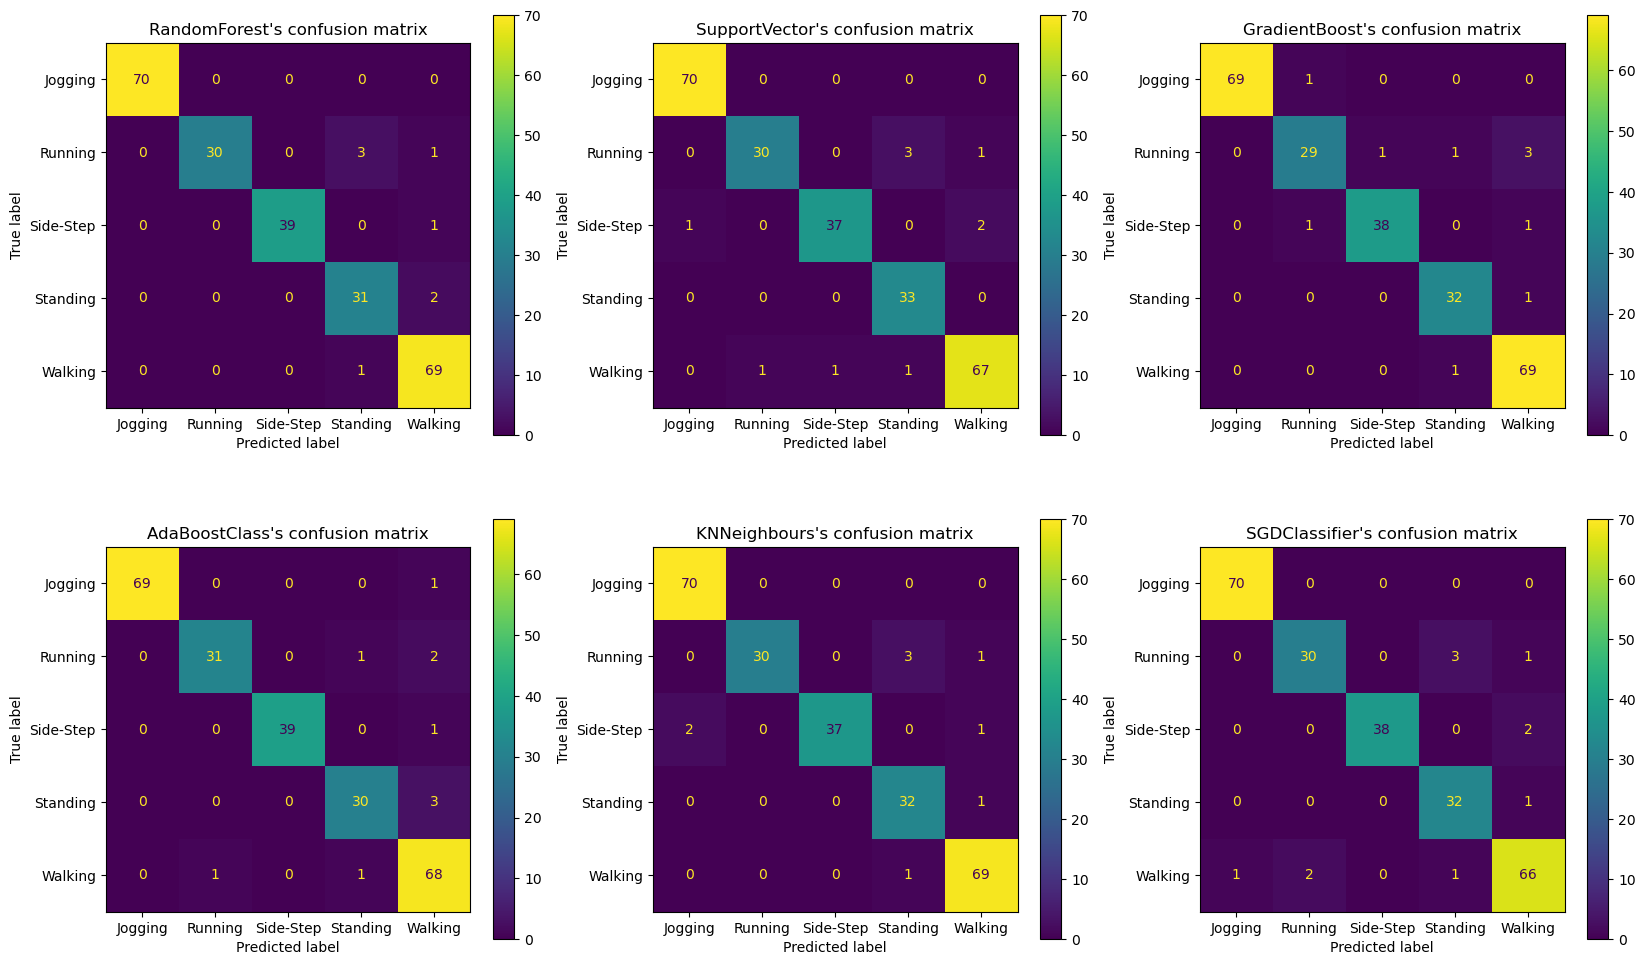

In [204]:
plot_matrix(classifiers)

From the above training and processing of performance metrics as well as the confusion matrix's going forward we will pick the random forest classifier, the gradient boost classifier and the knn classifier <br>
to fine tune and improve. I am selecting these three as they score the best f1 scores on the cross validation process and were the better of the 6 when observing their values in the confusion matrix's

## Implement Hyper parameterization

#### Optimisation Functions

In [208]:
# Function to optimise n_estimators for a classifier

def optimise_estimators(classifier, max_estimators, X, y):
    """
    Takes a classifier as input and calculates the accuracy score for a series of n_estimators from
    1 to max_estimators (int input provided) keeping track of each score for each number of estimators
    Printing out the best score and best number of estimators and returns FINISH THIS SENTENCE
    Params:
    classifier: Object - An uninitialized classifier that has the n_estimators hyper parameter
    max_estimators: int - Maximum number of estimators to test for
    X, y: numpy arrays - X and y values of a dataset
    """
    # List to hold all cross validation scores
    cv_scores = []
    # Hold the best cross validation score
    best_score = 0
    # Holds the number of estimators that returns the best cross val score
    best_estimator = 0
    # Keeps track of how many estimators haven't scored a new high score
    stop_counter = 0
    # The total number of estimators in a row that are allowed to not score a new high
    stop_limit = 10

    # Iterator through a number series from 1 to max_estimators
    for estimator in range(1, max_estimators):
        # Initialise the passed in classifier with n_estimators equal to the number of iterations so far
        clf = classifier(n_estimators = estimator)
        # Calculate the cross val score for the classifier on the X and y sets
        clf_score = cross_val_score(clf, X, y, cv = 10, scoring = "f1_macro")
        # Take the mean from all the cross fold from validation testing
        clf_score = clf_score.mean()
        # append the scores mean to the list hold all scores for each estimator value
        cv_scores.append(clf_score)

        # If the current cv score is better than all previous cv scores
        if clf_score > best_score:
            # Reassign the best score an the best number of estimators
            best_score = clf_score
            best_estimator = estimator
        else:
            # increment the counter that will auto stop the cross validation process if enough estimators
            # in a row haven't scored a high value
            stop_counter += 1
            if stop_counter > stop_limit:
                break

    # Print out the results
    print(f"Best score: {best_score}\tBest number of estimators: {best_estimator}")
    # Return the best estimator number and the list of training results.
    return best_estimator, cv_scores

In [209]:
def optimize_depth(classifier, estimators, depths, X, y):
    """
    
    """
    best_f1 = 0
    best_depth = 0
    depth_scores = []

    for depth in range(1 ,depths):
        clf_trained = classifier(n_estimators = estimators, max_depth = depth)
        cv_score = cross_val_score(clf_trained, X, y, cv = 10, scoring = "f1_macro").mean()

        depth_scores.append(cv_score)

        if cv_score > best_f1:
            best_f1 = cv_score
            best_depth = depth

    print(f"Best score {best_f1} \t Best_depth {best_depth}")
    return best_depth, depth_scores

In [210]:
def plot_tuning(name, series_1, series_2, series_3):
    """
     
    """
    fig, ax = plt.subplots(1,3, figsize=(22, 6))

    # Plot the first hyper parameter optimization decision curve
    ax[0].plot(np.arange(0, len(series_1)), series_1)
    ax[0].set_xlabel("Number of estimators")
    ax[0].set_ylabel("Cross validation score")
    ax[0].set_title(f"{name} N_estimator Hyper Parameter training")

    # Plot the second hyper parameter optimization decision curve
    ax[1].plot(np.arange(0, len(series_2)), series_2)
    ax[1].set_xlabel("Number of estimators")
    ax[1].set_ylabel("Cross validation score")
    ax[1].set_title(f"{name} Max_depth Hyper Parameter training")

    # Plot the final confusion matrix of the classifier on the test set
    ConfusionMatrixDisplay.from_predictions(series_3[0], series_3[1], display_labels = lb.classes_, ax=ax[2])
    ax[2].set_title(f"{name} Confusion matrix on Test set")
    plt.show()

### RandomForestClassifier

#### Optimizing n_estimators


In [213]:
rnd_tuned = RandomForestClassifier

number_of_estimators = 100

rnd_best_estimator, estimator_scores = optimise_estimators(rnd_tuned, number_of_estimators, X_train, y_train)



Best score: 0.9608809523809523	Best number of estimators: 13


#### Optimizing Max Depth

In [215]:
depths = 50
rnd_best_depth, depth_scores = optimize_depth(rnd_tuned, rnd_best_estimator, depths, X_train, y_train)

Best score 0.9633571428571429 	 Best_depth 4


#### Final Results for RandomForest

In [217]:
rnd_tuned = RandomForestClassifier(n_estimators=rnd_best_estimator, max_depth=rnd_best_depth)

classifiers = {"RandomForest (Pre tuning)": rnd,
              "RandomForest (Post tuning)": rnd_tuned}

performance_metrics(classifiers, X_train, y_train)


RandomForest (Pre tuning)		 accuracy: 0.95967	 F1: 0.95502
RandomForest (Post tuning)		 accuracy: 0.9595	 F1: 0.94564


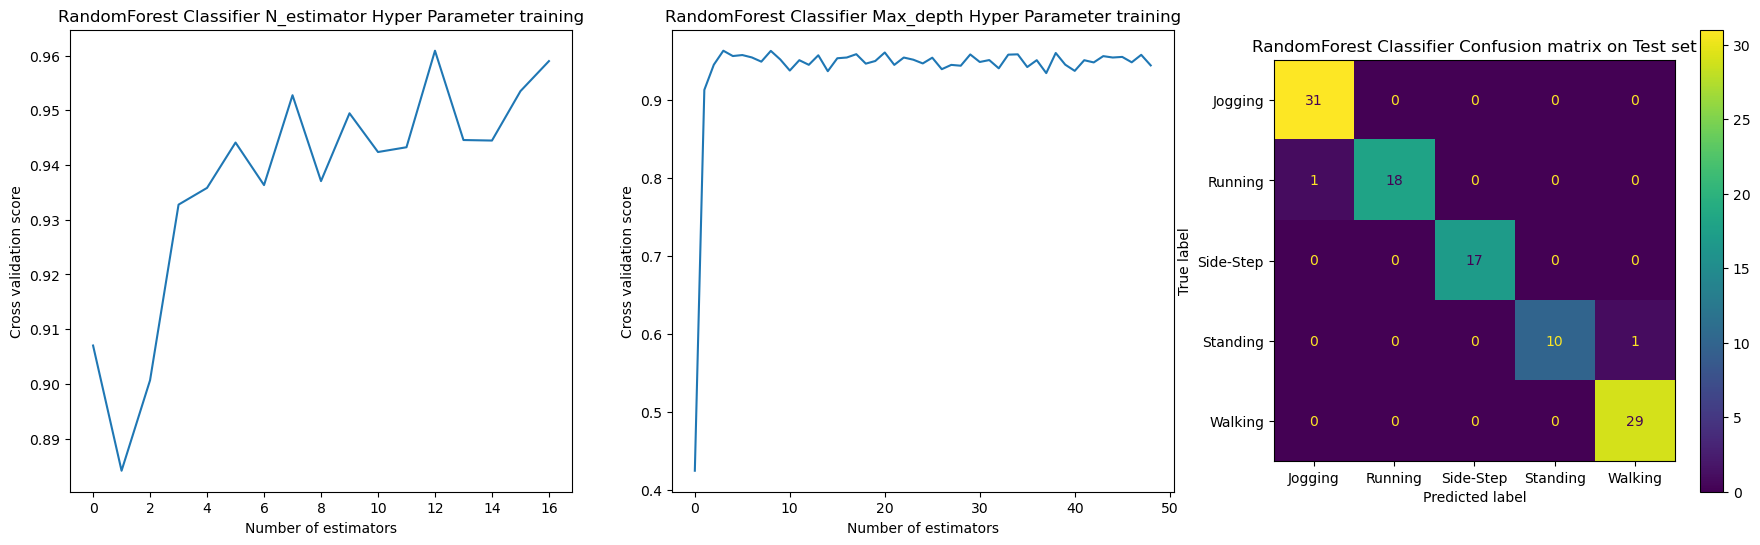

In [218]:
plot_tuning("RandomForest Classifier", estimator_scores, depth_scores, (y_test, y_pred))

The RandomForestClassifier with default of 100 estimators had an f1 score of 95.8%, so we have managed to pull another percent out of the classifier with a tuning of the number of <br>
estimators to use.

Above you can see that the Random Forest couldnt find a better number of estimators for 20 rounds after 15, so it was automatically stopped by our cut off feature in the function. This plot shows <br>
the scores for the first 25 odd rounds of testing, very quicly it gets over 90% but then goes back and fourth slowly creating higher highs and higher lows.

### GradientBoostClassifier

#### Optimizing n_estimators for the GradientBoostClassifier

In [223]:
gbc_tuned = GradientBoostingClassifier
gbc_best_estimator, estimator_scores = optimise_estimators(gbc_tuned, number_of_estimators, X_train, y_train)


Best score: 0.9286043956043957	Best number of estimators: 15


#### Optimizing Max Depth

In [225]:
depths = 50
gbc_best_depth, gbc_depth_scores = optimize_depth(gbc_tuned, gbc_best_estimator, depths, X_train, y_train)

Best score 0.9528186813186814 	 Best_depth 2


#### Final Results for GradientBoostingClassifier

In [227]:
gbc_tuned = GradientBoostingClassifier(n_estimators = gbc_best_estimator, max_depth = gbc_best_depth)

classifiers = {"GradientBoosting (Pre tuning)": gbc,
              "GradientBoosting (Post tuning)": gbc_tuned}

performance_metrics(classifiers, X_train, y_train)


GradientBoosting (Pre tuning)		 accuracy: 0.95967	 F1: 0.95062
GradientBoosting (Post tuning)		 accuracy: 0.9595	 F1: 0.95201


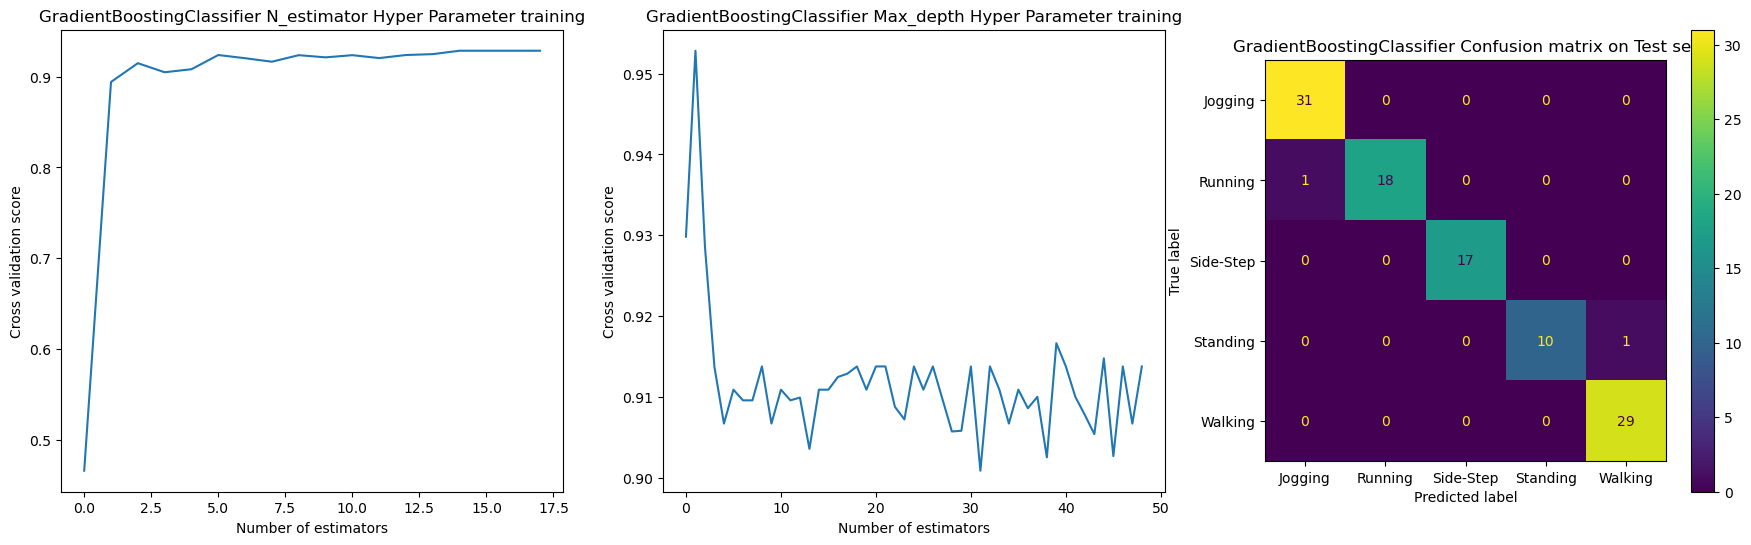

In [228]:
plot_tuning("GradientBoostingClassifier", estimator_scores, gbc_depth_scores, (y_test, y_pred))

### KNearestNeighbours

In [355]:
# Function to plot boundaries
def plot_boundaries(classifiers, best_train, best_test):
    """
    Takes in a dictionary of classifiers and plots the decision boundaries for each
    classifier as well as the training points and test points.
    Params:
    classifiers - a dictionary of classifiers to be plotted
    """
    # Create a figure to hold our plots
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Moving your colour maps up here to initalize them first before calling them in the colormesh
    cmap_bold = ListedColormap(['Red', 'Lime', 'Blue', 'Yellow', 'Magenta', 'darkorange'])
    cmap_light = ListedColormap(['LightPink', 'LightGreen', 'LightBlue', 'LightYellow', 'orange'])

    # Setting the boundaries for the knn classifiers on the two best features
    x_min, x_max = best_train[:, 0].min() - 1, best_train[:, 0].max() + 1
    y_min, y_max = best_train[:, 1].min() - 1, best_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Keep track of the column number
    col = 0

    # Iterate through all the classifiers passed in
    for name, classifier in classifiers.items():

        # Set their Z value
        Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot the boundaries and points for the classifier, the training and test sets as well as add labels 
        ax[col].pcolormesh(xx, yy, Z, cmap=cmap_light)
        ax[col].contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
        ax[col].scatter(best_train[:, 0], best_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', marker='o')
        ax[col].scatter(best_test[:, 0], best_test[:, 1], c=y_test, cmap=cmap_bold, marker='x')
        ax[col].set_xlabel('x_accel_max')
        ax[col].set_ylabel('y_gyro_max')

        # Set the title
        ax[col].set_title(f'{name} Decision Boundary (k={classifier.n_neighbors})')
        # plt.show()

        # Increment the column by 1 for the next classifier
        col += 1


In [318]:
best_feat1 = 0
best_feat2 = 0
best_score = 0

for f1 in range(X_train.shape[1]):
    for f2 in range(X_train.shape[1]):

        if f1 == f2:
            continue

        knn_tuned = KNeighborsClassifier()
        score = cross_val_score(knn_tuned, X_train[:,[f1, f2]], y_train, cv = 10, scoring = "f1_macro").mean()

        if score > best_score:
            best_score = score
            best_feat1 = f1
            best_feat2 = f2
            print(f"Feature 1:\t{f1}\tFeature 2:\t{f2}\tF1 score:\t{score}")

Feature 1:	0	Feature 2:	1	F1 score:	0.6458362095420919
Feature 1:	0	Feature 2:	2	F1 score:	0.6762801787136151
Feature 1:	0	Feature 2:	6	F1 score:	0.8276909468240736
Feature 1:	0	Feature 2:	17	F1 score:	0.9117814407814407
Feature 1:	2	Feature 2:	17	F1 score:	0.9147373770020829
Feature 1:	6	Feature 2:	10	F1 score:	0.9314865689865689
Feature 1:	8	Feature 2:	17	F1 score:	0.9369810744810744


In [322]:
knn_X_train = X_train[:, [best_feat1, best_feat2]]
knn_X_test = X_test[:, [best_feat1, best_feat2]]

#### Tuning K neighbours

In [324]:
best_neighbour = 0
best_f1 = 0
cv_scores = []

stop = 0
stoplim = 5

for neighbour in range(1,100):
    knn_tuned = KNeighborsClassifier(n_neighbors=neighbour)
    f1 = cross_val_score(knn_tuned, knn_X_train, y_train, cv = 10, scoring= "f1_macro").mean()

    cv_scores.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_neighbour = neighbour
    else:
        stop += 1
        if stop == stoplim:
            break

print(f"Best F1 score {best_f1}\t Best Neighbours {best_neighbour}")
# plot_tuning("KNearest Neighbours Classifier", cv_scores)

Best F1 score 0.9492735042735043	 Best Neighbours 3


#### Tuning "metric" or distance

In [326]:
distance_choices = ['minkowski', 'manhattan', 'euclidean']

for dist in distance_choices:
    knn_tuned = KNeighborsClassifier(n_neighbors = best_neighbour, metric = dist)
    f1 = cross_val_score(knn_tuned, knn_X_train, y_train, cv = 10, scoring = "f1_macro").mean()

    print(f"distance algo {dist}\t f1 score {f1}")

distance algo minkowski	 f1 score 0.9492735042735043
distance algo manhattan	 f1 score 0.9388131868131868
distance algo euclidean	 f1 score 0.9492735042735043


In [328]:
knn_tuned = KNeighborsClassifier(n_neighbors = best_neighbour, metric = "minkowski")

classifiers = {"Knn (Pre tuning)": knn,
              "Knn (Post tuning)": knn_tuned}

performance_metrics(classifiers, knn_X_train, y_train)

Knn (Pre tuning)		 accuracy: 0.9435	 F1: 0.93698
Knn (Post tuning)		 accuracy: 0.9555	 F1: 0.94927


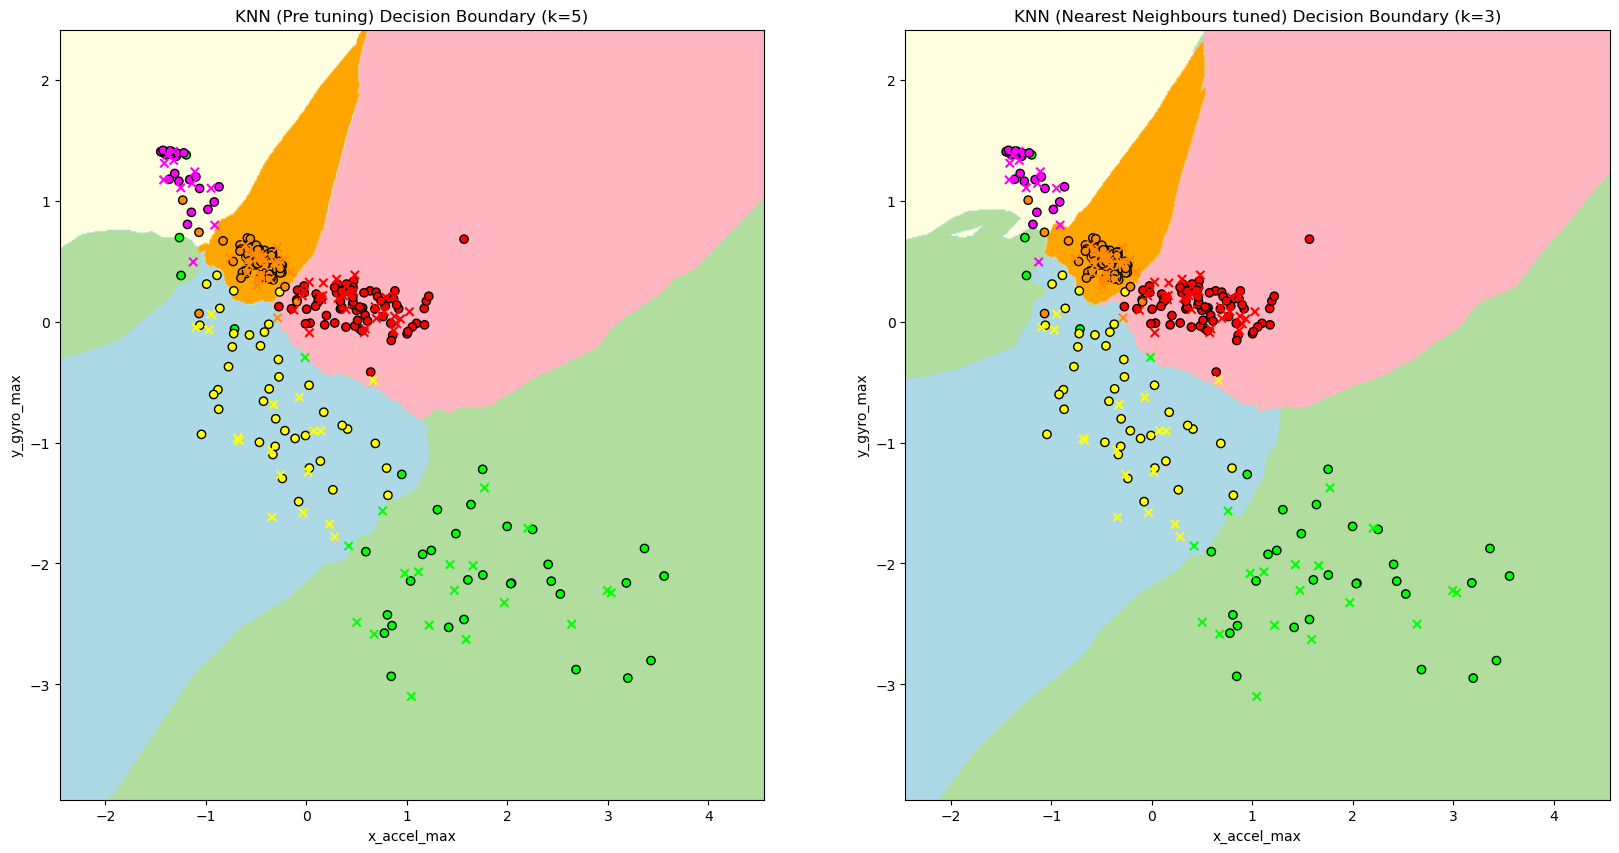

In [357]:
# Dictionary of classifiers to pass into the plot function (both the original knn and the tuned version)
classifiers = {"KNN (Pre tuning)": knn,
               "KNN (Nearest Neighbours tuned)": knn_tuned
              }

plot_boundaries(classifiers, knn_X_train, knn_X_test)

## Finally Fit the data and run the Classifiers on the Test set

In [338]:
fitted_clf = [("Random Forest (Pre tuned)",rnd_tuned.fit(X_train, y_train).predict(X_test)),
              ("Random Forest (Post tune)",rnd.fit(X_train, y_train).predict(X_test)),
              ("Gradient Boost (Pre tuned)",gbc.fit(X_train, y_train).predict(X_test)),
              ("Gradient Boost (Post tune)",gbc_tuned.fit(X_train, y_train).predict(X_test)),
              ("KNN Classifier (Pre tuned)",knn.fit(knn_X_train, y_train).predict(knn_X_test)),
              ("KNN Classifier (Post tune)",knn_tuned.fit(knn_X_train, y_train).predict(knn_X_test)),
             ]

for classifier in fitted_clf:
    name = classifier[0]
    clf = classifier[1]
    # score = clf.predict(X_test)
    score = f1_score(y_test, clf, average="macro")
    print(f"{name} \t- {score}")

Random Forest (Pre tuned) 	- 0.9622136422136421
Random Forest (Post tune) 	- 0.9759666688480249
Gradient Boost (Pre tuned) 	- 0.9785063513877074
Gradient Boost (Post tune) 	- 0.9785063513877074
KNN Classifier (Pre tuned) 	- 0.9345435661225135
KNN Classifier (Post tune) 	- 0.9224090038314176


## Re-Training our classifiers with hyper-parameter optimization (Feel free to change any of the below sections)

How to run this section:
- Train classifiers
- Run performance metrics on them
- Optimizing hyper parameters
- Show their training
- Run performance metrics on them
- conclude

#### Performance metrics for re-trained Classifiers

### Create visualizations for how the classifiers re-learnt 

## Conclude and summerise what was learnt

In [284]:
# A function to help calculate a set of performance metrics for multiple classifiers 

def classifiers_performance_metrics(classifiers, X_train, y_train, X_test, y_test):
    """
    
    """
    # Some vanity printing
    print("Classifier\t\tAccuracy\tPrecision\tRecall\t\tF1 Score")
    print("_________________________________________________________________________________")

    # Iterate through every classifier in the classifiers list of tuples passed in and set the first variable
    # to the y_pred value and the second variable as the name, systematically go through each and calculate 
    # various performance metrics before adding the classifier to the confusion matrix plot.
    for classifier in classifiers:
        # Train the classifier and get it's prediction score
        clf = classifier[0].fit(X_train, y_train)

        # Instead of using .predict like we would on the test set, we are using cross val predict to shield 
        # our algo from the test data
        clf_pred = cross_val_predict(classifier[0], X_train, y_train, cv = 10)
        # clf_pred = clf.predict(X_test)
        
        name = classifier[1]
        
        # Calculate metrics
        acc = round(accuracy_score(y_train, clf_pred), 5)
        pre = round(precision_score(y_train, clf_pred, average='macro', zero_division=False), 5)
        rec = round(recall_score(y_train, clf_pred, average='macro'), 5)
        f1s = round(f1_score(y_train, clf_pred, average='macro'), 5)

        # Print fancy looking metrics
        print(f"{name}\t|\t{acc}\t|\t{pre}\t|\t{rec}\t|\t{f1s}")

In [286]:
# I DID IT, THIS IS HOW YOU LOOK FOR OVERFITTING FINALLY

def overfit_test(classifiers, X, y):
    """
    Takes in a dictionary of unfitted classifiers as well as a training X and y set of values and 
    tests the classifiers for over training by using cross val score and cross val predict. A higher
    Score on the benchmark compared to the predicted accuracy would signal overfitting of the data and
    lower scores on the benchmark would point to underfitting of the data or poor data in general
    Params:
    classifiers - A dictionary containing all classifiers to check for over fitting
    X - Normally the X_train set of data
    y - Normally the y_train set of data
    """
    # Some vanity printing
    print("Classifier \t\t\t Training Score \t\t Prediciton Score")
    print("______________________________________________________________________________________")
    
    # For each classifier in the dictionary
    for name, classifier in classifiers.items():

        # run cross val score to get the accuracy score for each class of the fitted training data
        benchmark = cross_val_score(classifier, X, y, cv = 10, scoring = "accuracy")

        # Run cross val predict to get a set of predicted values from the training set 
        prediction_values = cross_val_predict(classifier, X, y, cv = 10)

        # Average out all the accuracy scores from all classes
        benchmark = benchmark.mean()
        # Get the accuracy score for the classifier
        prediction_accuracy = accuracy_score(y_train, prediction_values)
        # Print the name of classifier, it's accuracy score on the fitting data and on the 
        # predicted value
        print(f"{name}\t | \t {benchmark}\t | \t {prediction_accuracy}")

### Training our classifiers

In [295]:
rnd = RandomForestClassifier(n_estimators=100)
gbc = GradientBoostingClassifier(n_estimators = 100)
svc = SVC(C = 1, kernel="rbf", degree = 3, gamma ="scale")

classifiers = [(rnd, "RandomForest"), (svc, "SupportVector"), (gbc, "GradientBoost")]
classifiers_performance_metrics(classifiers, X_train, y_train, X_test, y_test)

Classifier		Accuracy	Precision	Recall		F1 Score
_________________________________________________________________________________
RandomForest	|	0.96356	|	0.96363	|	0.95364	|	0.95755
SupportVector	|	0.95951	|	0.95528	|	0.9529	|	0.95294
GradientBoost	|	0.95951	|	0.95669	|	0.94881	|	0.95214


Our classifier's all look to be doing very good.... a little to good, perhaps we need to test for overfitting as they all seem to be over<br>
95% accross all our metrics, maybe the data is just very clean. We won't know until we run some simple tests to see.

In [238]:
# Dictionary of classifiers to use for over testing
class_dic = {"RandomForestClassifier": rnd,
             "GradientBoostClassifier": gbc,
             "SupportVectorClassifier": svc,
            }

# Run the over testing function
overfit_test(class_dic, X_train, y_train)

Classifier 			 Training Score 		 Prediciton Score
______________________________________________________________________________________
RandomForestClassifier	 | 	 0.9638333333333333	 | 	 0.9635627530364372
GradientBoostClassifier	 | 	 0.9596666666666666	 | 	 0.9595141700404858
SupportVectorClassifier	 | 	 0.9596666666666666	 | 	 0.9595141700404858


From the above test it would see like our data isn't over fitted at all. If it was we should be seeing a much higher training
socre compared to the prediciton score, this is due to the classifiers tightly fitting the data to the training set and when 
we run cross val predict, if the scores were much worse it would indicate the classifier didn't generalize to the prediction 
set of data well, leading us to the conclusion it was overfitted. 

With the classifiers trained and this test done, let's move onto selecting and training some hyperparameters for our classifiers
to see if we can achieve even better preformance metric scores without over fitting our classifiers.